In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torchinfo import summary

In [2]:
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
train_df = pd.read_csv("/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/train_answers.csv")
train_df

,img_id,target_feature
0,17363,2
1,8612,5
2,8244,0
3,9264,0
4,5382,6
...,...,...
12362,11503,4
12363,12201,6
12364,5489,3
12365,883,5


In [4]:
train_df["target_feature"].value_counts(normalize=True) 
# Видим, что в исходных данных всего 16 типов данных, а не 20, как в справочнике - потом надо переделать модель на 16 классов
# Потом можно добавить график

target_feature
0     0.203121
3     0.135845
9     0.098892
5     0.079405
6     0.064688
16    0.060888
4     0.060807
8     0.043099
2     0.042856
11    0.042694
12    0.037924
13    0.035740
18    0.033153
10    0.031536
14    0.018436
1     0.010916
Name: proportion, dtype: float64

In [5]:
# Если делать модель на 20 классах, 
# то на одних и тех же данных то метрика на валидации будет отличаться от метрики на нашей валидации.
# Например у нас f1 0.39, а на лидерборде около 0.5. Если классов сделать 16 (как на самом деле есть), 
# то на этих же предсказаниях метрика будет уже 0.49 (f1 чуствительна к количеству классов)
# Самое просто это перекодировать классы. Например (просто берем по уменьшении доли класс)

target_feature_to_class_id = {
    0:0,
    3:1,
    9:2,
    5:3,
    6:4,
    16:5,
    4:6,
    8:7,
    2:8,
    11:9,
    12:10,
    13:11,
    18:12,
    10:13,
    14:14,
    1:15,
}

class_id_to_target_feature = {v:k for k,v in target_feature_to_class_id.items()}

print(f'target_feature -> class_id', target_feature_to_class_id)
print(f'class_id -> target_feature', class_id_to_target_feature)

target_feature -> class_id {0: 0, 3: 1, 9: 2, 5: 3, 6: 4, 16: 5, 4: 6, 8: 7, 2: 8, 11: 9, 12: 10, 13: 11, 18: 12, 10: 13, 14: 14, 1: 15}
class_id -> target_feature {0: 0, 1: 3, 2: 9, 3: 5, 4: 6, 5: 16, 6: 4, 7: 8, 8: 2, 9: 11, 10: 12, 11: 13, 12: 18, 13: 10, 14: 14, 15: 1}


In [6]:
# Заменим 20 классов на новые идентификатры 16 классов
train_df['target_feature'] = train_df['target_feature'].replace(target_feature_to_class_id)
train_df

,img_id,target_feature
0,17363,8
1,8612,3
2,8244,0
3,9264,0
4,5382,4
...,...,...
12362,11503,6
12363,12201,4
12364,5489,1
12365,883,3


In [7]:
# Разделим данные на train и valid сохранением доли таргета
train_df, valid_df = train_test_split(train_df, train_size=0.8, random_state=5, shuffle=True, stratify=train_df["target_feature"])

In [8]:
# Проверим, что доли таргета не поменялись. Потом можно добавить график
print(train_df["target_feature"].value_counts(normalize=True))
print(valid_df["target_feature"].value_counts(normalize=True))

target_feature
0     0.203174
1     0.135854
2     0.098858
3     0.079450
4     0.064692
5     0.060851
6     0.060851
7     0.043061
8     0.042859
9     0.042656
10    0.037906
11    0.035783
12    0.033155
13    0.031537
14    0.018397
15    0.010917
Name: proportion, dtype: float64
target_feature
0     0.202910
1     0.135812
2     0.099030
3     0.079224
4     0.064673
5     0.061035
6     0.060631
7     0.043250
8     0.042846
9     0.042846
10    0.037995
11    0.035570
12    0.033145
13    0.031528
14    0.018593
15    0.010914
Name: proportion, dtype: float64


In [9]:
# Класс для загрузки картинок и информации о них
class ImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.data = df
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = str(self.data.iloc[idx]['img_id']) + ".jpg" 
        img_path = os.path.join(self.img_dir, img_name)
        
        # Читаем изображение
        image = read_image(img_path)
        
        # Получаем метку из CSV
        label = self.data.iloc[idx]['target_feature']
        
        # Применяем трансформации, если они заданы
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [10]:
from torchvision.transforms import v2
# https://pytorch.org/vision/stable/transforms.html

transform_train = v2.Compose([
    v2.Resize(256),    
    v2.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.RandomApply([v2.ColorJitter(0.1, 0.1, 0.1, 0.02)], p=0.8),
    v2.RandomPerspective(distortion_scale=0.2, p=0.3),
    v2.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    v2.RandomApply([v2.GaussianBlur(kernel_size=3)], p=0.3),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_valid = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageDataset(
    df=train_df,
    img_dir="/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_train",
    transform=transform_train
)

valid_dataset = ImageDataset(
    df=valid_df,
    img_dir="/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_train",
    transform=transform_valid
)

In [11]:
# Класс для загрузки картинок и информации о них
class ImageDatasetCached(Dataset):
    def __init__(self, df, img_dir, transform_disk=None, transform_mem=None):
        self.data = df
        self.img_dir = img_dir
        self.transform_disk = transform_disk
        self.transform_mem = transform_mem

        print("Читаем даннные в память")
        self.cache_list = []
        for idx in range(len(self.data)):
            item = self.get_item_from_disk(idx)
            self.cache_list.append(item)
            
    def get_item_from_disk(self, idx):
        img_name = str(self.data.iloc[idx]['img_id']) + ".jpg" 
        img_path = os.path.join(self.img_dir, img_name)
        
        # Читаем изображение
        image = read_image(img_path)
        
        # Получаем метку из CSV
        label = self.data.iloc[idx]['target_feature']
        
        # Применяем трансформации, если они заданы
        if self.transform_disk:
            image = self.transform_disk(image)
            
        return image, label
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.cache_list[idx]
        
        # Применяем трансформации, если они заданы
        if self.transform_mem:
            image = self.transform_mem(image)
            
        return image, label

In [12]:
from torchvision.transforms import v2
# https://pytorch.org/vision/stable/transforms.html

transform_train_disk = v2.Compose([
    v2.Resize(256),    
])

transform_train_mem = v2.Compose([
    v2.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=10),
    v2.RandomApply([v2.ColorJitter(0.1, 0.1, 0.1, 0.02)], p=0.8),
    v2.RandomPerspective(distortion_scale=0.2, p=0.3),
    v2.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    v2.RandomApply([v2.GaussianBlur(kernel_size=3)], p=0.3),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_valid_disk = v2.Compose([
    v2.Resize(224),
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = ImageDatasetCached(
    df=train_df,
    img_dir="/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_train",
    transform_disk=transform_train_disk,
    transform_mem=transform_train_mem,
)

valid_dataset = ImageDatasetCached(
    df=valid_df,
    img_dir="/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_train",
    transform_disk=transform_valid_disk,
)

Читаем даннные в память
Читаем даннные в память


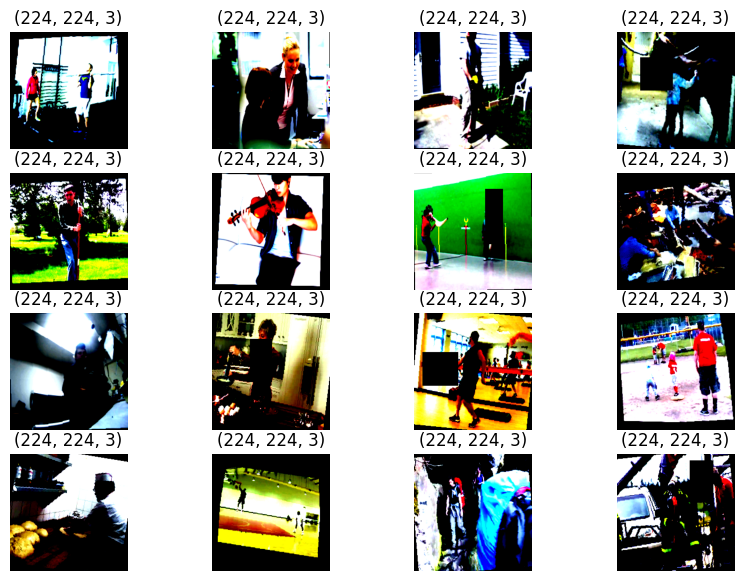

In [13]:
plt.figure(figsize=(10, 7))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img, label = train_dataset[i]
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis('off') 
    plt.title(f"{img.shape}")

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
# !rm -r /kaggle/working/models

# Функции создания моделей

In [16]:
# Сделаем модель с skip-conection
def create_resnet18_model(dropout_conv = 0.1, dropout_linear = 0.5, max_drop_path_rate=0.2):

    class DropPath(nn.Module):
        def __init__(self, drop_prob=0.0):
            super().__init__()
            self.drop_prob = drop_prob

        def forward(self, x):
            if self.drop_prob == 0. or not self.training:
                return x
            keep_prob = 1 - self.drop_prob
            shape = (x.shape[0],) + (1,) * (x.ndim - 1)
            random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
            random_tensor.floor_()
            return x.div(keep_prob) * random_tensor

    class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride, drop_path_prob=0.1):
            super().__init__()

            self.main = nn.Sequential(
                nn.BatchNorm2d(in_channels),
                nn.LeakyReLU(0.1),
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.Dropout2d(dropout_conv),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.1),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.Dropout2d(dropout_conv),
            )

            self.skip = nn.Identity() if in_channels == out_channels and stride == 1 else nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels),
            )

            self.drop_path = DropPath(drop_prob=drop_path_prob)
            self.final_relu = nn.LeakyReLU(0.1)

        def forward(self, x):
            return self.final_relu(self.drop_path(self.main(x)) + self.skip(x))


    drop_path_rate = [x.item() for x in torch.linspace(0, max_drop_path_rate, 8)]  # 8 blocks total
    channels = 64

    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=7, stride=2, padding=3, bias=False),
        nn.BatchNorm2d(channels),
        nn.LeakyReLU(0.1),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

        ResidualBlock(in_channels=channels, out_channels=channels, stride=1, drop_path_prob=drop_path_rate[0]),
        ResidualBlock(in_channels=channels, out_channels=channels, stride=1, drop_path_prob=drop_path_rate[1]),

        ResidualBlock(in_channels=channels, out_channels=channels*2, stride=2, drop_path_prob=drop_path_rate[2]),
        ResidualBlock(in_channels=channels*2, out_channels=channels*2, stride=1, drop_path_prob=drop_path_rate[3]),

        ResidualBlock(in_channels=channels*2, out_channels=channels*4, stride=2, drop_path_prob=drop_path_rate[4]),
        ResidualBlock(in_channels=channels*4, out_channels=channels*4, stride=1, drop_path_prob=drop_path_rate[5]),

        ResidualBlock(in_channels=channels*4, out_channels=channels*8, stride=2, drop_path_prob=drop_path_rate[6]),
        ResidualBlock(in_channels=channels*8, out_channels=channels*8, stride=1, drop_path_prob=drop_path_rate[7]),

        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Dropout(dropout_linear),
        nn.Linear(in_features=channels*8, out_features=16),
    )

    print(summary(model, input_size=(256, 3, 224, 224), col_names=["input_size", "output_size", "num_params"], depth=3))
    return model

create_resnet18_model()

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [256, 3, 224, 224]        [256, 16]                 --
├─Conv2d: 1-1                            [256, 3, 224, 224]        [256, 64, 112, 112]       9,408
├─BatchNorm2d: 1-2                       [256, 64, 112, 112]       [256, 64, 112, 112]       128
├─LeakyReLU: 1-3                         [256, 64, 112, 112]       [256, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [256, 64, 112, 112]       [256, 64, 56, 56]         --
├─ResidualBlock: 1-5                     [256, 64, 56, 56]         [256, 64, 56, 56]         --
│    └─Sequential: 2-1                   [256, 64, 56, 56]         [256, 64, 56, 56]         --
│    │    └─BatchNorm2d: 3-1             [256, 64, 56, 56]         [256, 64, 56, 56]         128
│    │    └─LeakyReLU: 3-2               [256, 64, 56, 56]         [256, 64, 56, 56]         --
│    │    └─Conv2d: 3-3       

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.1)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): ResidualBlock(
    (main): Sequential(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): Dropout2d(p=0.1, inplace=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.1)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): Dropout2d(p=0.1, inplace=False)
    )
    (skip): Identity()
    (drop_path): DropPath()
    (final_relu): LeakyReLU(negative_slope=0.1)
  )
  (5): Residual

# Вспомогательные функции (обучение/предсказание/графики)

In [17]:
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import Loss, Accuracy, Average, RunningAverage, Precision, Recall, Fbeta
from ignite.utils import convert_tensor

def train_model(
    model, 
    loss_fn, 
    optimizer, 
    train_dataloader, 
    valid_dataloader, 
    max_epoch, 
    device, 
    validation_patience=5, 
    validation_lr_reduce_patience=2, 
    model_name_prefix='baseline',
):
    
    # Создание trainer
    train_engine = create_supervised_trainer(
        model=model,
        optimizer=optimizer,
        loss_fn=loss_fn,
        device=device,
        output_transform=lambda x, y, y_pred, loss: (loss.item(), y_pred, y)
    )

    # Добавляем метрики для подсчета train_loss
    train_loss = Average(output_transform=lambda x: x[0])
    train_loss.attach(train_engine, 'train_loss')

    # Создаем метрики Precision и Recall
    P = Precision(average=False, output_transform=lambda x: (x[1], x[2]))
    R = Recall(average=False, output_transform=lambda x: (x[1], x[2]))

    # Создаем F1-метрику (Fbeta с beta=1)
    # https://pytorch.org/ignite/generated/ignite.metrics.Fbeta.html#ignite.metrics.Fbeta
    train_metric = Fbeta(beta=1.0, precision=P, recall=R)
    train_metric.attach(train_engine, "train_f1")

    # Создание Engine для валидации
    valid_engine = create_supervised_evaluator(
        model=model,
        device=device,
        output_transform=lambda x, y, y_pred: (loss_fn(input=y_pred, target=y).item(), y_pred, y)
    )

    # Добавляем метрики для подсчета train_loss
    valid_loss = Average(output_transform=lambda x: x[0])
    valid_loss.attach(valid_engine, 'valid_loss')

    # Создаем метрики Precision и Recall для валидации
    P = Precision(average=False, output_transform=lambda x: (x[1], x[2]))
    R = Recall(average=False, output_transform=lambda x: (x[1], x[2]))

    # Создаем F1-метрику (Fbeta с beta=1)
    # https://pytorch.org/ignite/generated/ignite.metrics.Fbeta.html#ignite.metrics.Fbeta
    valid_metric = Fbeta(beta=1.0, precision=P, recall=R)
    valid_metric.attach(valid_engine, "valid_f1")

    train_loss_history = []
    train_f1_history = []
    valid_loss_history = []
    valid_f1_history = []

    # После каждой эпохи train_engine должен запускать valid_engine
    # Создадим обработчик события - конец эпохи у train_engine
    def compute_epoch_results(engine):
        valid_engine.run(valid_dataloader, epoch_length=None)
        train_loss = engine.state.metrics['train_loss']
        train_f1 = engine.state.metrics['train_f1']
        valid_loss = valid_engine.state.metrics['valid_loss']
        valid_f1 = valid_engine.state.metrics['valid_f1']

        train_loss_history.append(train_loss)
        train_f1_history.append(train_f1)
        valid_loss_history.append(valid_loss)
        valid_f1_history.append(valid_f1)

        print(f"Эпоха: {engine.state.epoch} train_loss: {train_loss:.4f} valid_loss: {valid_loss:.4f} train_f1: {train_f1:.4f} valid_f1: {valid_f1:.4f} lr: {reducelr_scheduler.get_last_lr()[0]}")

        # Вызовем scheduler - он проверит нужно ли менять lr и если надо - сделает это
        reducelr_scheduler.step(valid_f1)

    train_engine.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)

    # Добавляем EarlyStopping
    early_stop_handler = EarlyStopping(
        patience=validation_patience,  # количество эпох без улучшения
        score_function=lambda engine: valid_engine.state.metrics['valid_f1'],
        trainer=train_engine
    )

    # Прикрепляем обработчик к train_engine
    train_engine.add_event_handler(Events.EPOCH_COMPLETED, early_stop_handler)

    # Создадим scheduler, который будет уменьшать learning rate в optimizer после нескольких epoch без улучшения
    reducelr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,       # Наш оптимизатор
        mode="max",      # Мы хотим максимизировать f1
        factor=0.5,      # Во сколько раз уменьшать lr
        patience=validation_lr_reduce_patience, # Сколько эпох ждать до уменьшения
        threshold=1e-5,  # На сколько должно быть улучшение относительно лучшего
        cooldown=0,      # Сколько эпох ждать после снижения
        min_lr=1e-6,     # Минимальный lr (дальше уже не уменьшать)
    )

    # Добавляем сохранение лучших моделей
    checkpointer = ModelCheckpoint(
        score_function=lambda engine: valid_engine.state.metrics['valid_f1'],
        dirname="models",
        filename_prefix=model_name_prefix,
        n_saved=3,
        create_dir=True,
        require_empty=False,
    )
    # Прикрепляем обработчик к train_engine
    train_engine.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'model': model})

    # Создаем прогресс-бар
    progress_bar = ProgressBar()

    # Привязываем к trainer
    progress_bar.attach(train_engine)

    # Запускаем обучение
    engine_output = train_engine.run(train_dataloader, max_epochs=max_epoch, epoch_length=None)

    # Формируем справочник с результатами
    train_result = {}
    train_result["train_loss_history"] = train_loss_history
    train_result["valid_loss_history"] = valid_loss_history
    train_result["train_f1_history"] = train_f1_history
    train_result["valid_f1_history"] = valid_f1_history
    train_result['checkpointer'] = checkpointer
    return train_result

/usr/local/lib/python3.10/dist-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [18]:
def predict_model_pred(model, dataloader, device):
    test_engine = create_supervised_evaluator(
        model=model,
        device=device,
        output_transform=lambda x, y, y_pred: y_pred
    )
    
    pred_list = []
    
    def compute_epoch_results(engine):
        pred_list.append(engine.state.output.cpu().numpy())
        
    test_engine.add_event_handler(Events.ITERATION_COMPLETED, compute_epoch_results)
    
    # Создаем прогресс-бар
    progress_bar = ProgressBar()
    
    # Привязываем к trainer
    progress_bar.attach(test_engine)
    
    # Запускаем предсказание
    test_engine_output = test_engine.run(dataloader)

    # Объединяем предсказания в разных batch
    pred = np.concatenate(pred_list)
    print(pred.shape)

    return pred
    
def predict_model(model, dataloader, device):
    test_engine = create_supervised_evaluator(
        model=model,
        device=device,
        output_transform=lambda x, y, y_pred: y_pred
    )
    
    pred = predict_model_pred(model, dataloader, device)

    # Максимум это предсказанный класс
    pred = pred.argmax(1)
    print(pred.shape)

    return pred

In [19]:
def plot_train_history(train_loss_history, valid_loss_history, train_f1_history, valid_f1_history):
    plt.plot(range(len(train_loss_history)), train_loss_history, label="train_loss")
    plt.plot(range(len(valid_loss_history)), valid_loss_history, label="valid_loss")
    
    best_epoch = np.argmax(np.array(valid_f1_history))
    plt.axvline(x=best_epoch, color='red', label="best valid_f1 epoch")
    
    plt.legend()
    plt.show()
    
    plt.plot(range(len(train_f1_history)), train_f1_history, label="train_f1")
    plt.plot(range(len(valid_f1_history)), valid_f1_history, label="valid_f1")
    
    plt.axvline(x=best_epoch, color='red', label="best valid_f1 epoch")
    
    plt.legend()
    plt.show()

def plot_train_history_from_results(train_results):
    plot_train_history(
        train_results['train_loss_history'],
        train_results['valid_loss_history'],
        train_results['train_f1_history'],
        train_results['valid_f1_history'],
    )

# Основной код обучения

In [20]:
# У нас доли классов разные. А метрика f1-macro, которая усредняется по классам.
# Т.е. класс с маленькой долей влияет так же как и класс с большой долей.
# Рассчитаем возможные веса классов
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['target_feature'].values),  # targets — массив меток (например, из train.csv)
    y=train_df['target_feature'].values
)
print(class_weights)

[0.30761816 0.46005394 0.63222137 0.78665712 0.96611328 1.02709718
 1.02709718 1.45143779 1.4582842  1.4651955  1.64883333 1.74664548
 1.88509909 1.98177083 3.39732143 5.72511574]


In [21]:
# Создаем модель
model = create_resnet18_model(dropout_conv = 0.1, dropout_linear = 0.5)
model = model.to(device)

# Создаем loss функцию
loss_fn = nn.CrossEntropyLoss(
    weight=torch.tensor(class_weights, dtype=torch.float32).to(device),  # class_weights - усилим вес редких классов
    label_smoothing = 0.1,  # Сглаживание целевых классов
    )

# Создаем оптимизатор, который будет обновлять веса модели с указаным lr. Зададим weight_decay, который будет стараться минимизировать веса модели
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, weight_decay=1e-4)

# Создаем даталоадеры с данными в батчах
batch_size = 256

# У нас не очень много данных, но мы хотим батс 256 так что увеличим датасет в 4 раза 
from torch.utils.data import ConcatDataset
train_dataloader = DataLoader(ConcatDataset([train_dataset, train_dataset, train_dataset, train_dataset]), batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Запускаем обучение модели
train_results = train_model(
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    max_epoch = 100,
    validation_patience = 5,
    validation_lr_reduce_patience=2,
    model_name_prefix='resnet18',
    device=device
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [256, 3, 224, 224]        [256, 16]                 --
├─Conv2d: 1-1                            [256, 3, 224, 224]        [256, 64, 112, 112]       9,408
├─BatchNorm2d: 1-2                       [256, 64, 112, 112]       [256, 64, 112, 112]       128
├─LeakyReLU: 1-3                         [256, 64, 112, 112]       [256, 64, 112, 112]       --
├─MaxPool2d: 1-4                         [256, 64, 112, 112]       [256, 64, 56, 56]         --
├─ResidualBlock: 1-5                     [256, 64, 56, 56]         [256, 64, 56, 56]         --
│    └─Sequential: 2-1                   [256, 64, 56, 56]         [256, 64, 56, 56]         --
│    │    └─BatchNorm2d: 3-1             [256, 64, 56, 56]         [256, 64, 56, 56]         128
│    │    └─LeakyReLU: 3-2               [256, 64, 56, 56]         [256, 64, 56, 56]         --
│    │    └─Conv2d: 3-3       

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ignite/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


[1/155]   1%|           [00:00<?]

Эпоха: 1 train_loss: 2.9123 valid_loss: 2.7213 train_f1: 0.0866 valid_f1: 0.1187 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 2 train_loss: 2.7432 valid_loss: 2.6884 train_f1: 0.1296 valid_f1: 0.1220 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 3 train_loss: 2.6686 valid_loss: 2.5815 train_f1: 0.1570 valid_f1: 0.1761 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 4 train_loss: 2.6036 valid_loss: 2.5616 train_f1: 0.1799 valid_f1: 0.1826 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 5 train_loss: 2.5528 valid_loss: 2.5121 train_f1: 0.1983 valid_f1: 0.2054 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 6 train_loss: 2.5084 valid_loss: 2.4305 train_f1: 0.2202 valid_f1: 0.2591 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 7 train_loss: 2.4523 valid_loss: 2.4059 train_f1: 0.2409 valid_f1: 0.2569 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 8 train_loss: 2.4111 valid_loss: 2.3717 train_f1: 0.2588 valid_f1: 0.2675 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 9 train_loss: 2.3606 valid_loss: 2.3217 train_f1: 0.2830 valid_f1: 0.2964 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 10 train_loss: 2.3091 valid_loss: 2.3115 train_f1: 0.3019 valid_f1: 0.3147 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 11 train_loss: 2.2594 valid_loss: 2.2776 train_f1: 0.3233 valid_f1: 0.3174 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 12 train_loss: 2.2076 valid_loss: 2.2592 train_f1: 0.3452 valid_f1: 0.3442 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 13 train_loss: 2.1560 valid_loss: 2.1670 train_f1: 0.3660 valid_f1: 0.3682 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 14 train_loss: 2.1033 valid_loss: 2.1724 train_f1: 0.3868 valid_f1: 0.3607 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 15 train_loss: 2.0420 valid_loss: 2.1178 train_f1: 0.4142 valid_f1: 0.4110 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 16 train_loss: 1.9934 valid_loss: 2.1098 train_f1: 0.4308 valid_f1: 0.4079 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 17 train_loss: 1.9346 valid_loss: 2.0363 train_f1: 0.4525 valid_f1: 0.4450 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 18 train_loss: 1.8907 valid_loss: 2.0821 train_f1: 0.4747 valid_f1: 0.4353 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 19 train_loss: 1.8399 valid_loss: 2.0107 train_f1: 0.4957 valid_f1: 0.4655 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 20 train_loss: 1.7800 valid_loss: 2.0047 train_f1: 0.5238 valid_f1: 0.4701 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 21 train_loss: 1.7292 valid_loss: 2.0111 train_f1: 0.5484 valid_f1: 0.4930 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 22 train_loss: 1.6842 valid_loss: 1.9601 train_f1: 0.5671 valid_f1: 0.4950 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 23 train_loss: 1.6462 valid_loss: 1.8984 train_f1: 0.5847 valid_f1: 0.5035 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 24 train_loss: 1.6071 valid_loss: 1.8999 train_f1: 0.6050 valid_f1: 0.5444 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 25 train_loss: 1.5684 valid_loss: 1.9477 train_f1: 0.6266 valid_f1: 0.5349 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 26 train_loss: 1.5481 valid_loss: 1.8953 train_f1: 0.6367 valid_f1: 0.5510 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 27 train_loss: 1.5137 valid_loss: 1.9065 train_f1: 0.6518 valid_f1: 0.5643 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 28 train_loss: 1.4792 valid_loss: 1.8783 train_f1: 0.6680 valid_f1: 0.5662 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 29 train_loss: 1.4553 valid_loss: 1.8524 train_f1: 0.6818 valid_f1: 0.5667 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 30 train_loss: 1.4273 valid_loss: 1.8746 train_f1: 0.6956 valid_f1: 0.5826 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 31 train_loss: 1.4058 valid_loss: 1.8732 train_f1: 0.7054 valid_f1: 0.5735 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 32 train_loss: 1.3783 valid_loss: 1.8471 train_f1: 0.7222 valid_f1: 0.5981 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 33 train_loss: 1.3731 valid_loss: 1.7940 train_f1: 0.7242 valid_f1: 0.6083 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 34 train_loss: 1.3525 valid_loss: 1.8142 train_f1: 0.7326 valid_f1: 0.5849 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 35 train_loss: 1.3348 valid_loss: 1.8186 train_f1: 0.7441 valid_f1: 0.5977 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 36 train_loss: 1.3261 valid_loss: 1.7891 train_f1: 0.7483 valid_f1: 0.6130 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 37 train_loss: 1.3218 valid_loss: 1.8275 train_f1: 0.7525 valid_f1: 0.5966 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 38 train_loss: 1.2946 valid_loss: 1.8019 train_f1: 0.7662 valid_f1: 0.5975 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 39 train_loss: 1.2898 valid_loss: 1.7696 train_f1: 0.7691 valid_f1: 0.6256 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 40 train_loss: 1.2857 valid_loss: 1.7413 train_f1: 0.7698 valid_f1: 0.6198 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 41 train_loss: 1.2669 valid_loss: 1.7548 train_f1: 0.7801 valid_f1: 0.6224 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 42 train_loss: 1.2608 valid_loss: 1.8082 train_f1: 0.7842 valid_f1: 0.5919 lr: 0.001


[1/155]   1%|           [00:00<?]

Эпоха: 43 train_loss: 1.1778 valid_loss: 1.7020 train_f1: 0.8289 valid_f1: 0.6554 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 44 train_loss: 1.1381 valid_loss: 1.6841 train_f1: 0.8527 valid_f1: 0.6628 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 45 train_loss: 1.1197 valid_loss: 1.6842 train_f1: 0.8621 valid_f1: 0.6677 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 46 train_loss: 1.1112 valid_loss: 1.6823 train_f1: 0.8667 valid_f1: 0.6691 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 47 train_loss: 1.1095 valid_loss: 1.6724 train_f1: 0.8676 valid_f1: 0.6697 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 48 train_loss: 1.1032 valid_loss: 1.7077 train_f1: 0.8690 valid_f1: 0.6611 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 49 train_loss: 1.1079 valid_loss: 1.6835 train_f1: 0.8699 valid_f1: 0.6626 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 50 train_loss: 1.1036 valid_loss: 1.6516 train_f1: 0.8709 valid_f1: 0.6778 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 51 train_loss: 1.0987 valid_loss: 1.6749 train_f1: 0.8720 valid_f1: 0.6656 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 52 train_loss: 1.0993 valid_loss: 1.6876 train_f1: 0.8725 valid_f1: 0.6618 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 53 train_loss: 1.0982 valid_loss: 1.6845 train_f1: 0.8723 valid_f1: 0.6540 lr: 0.0005


[1/155]   1%|           [00:00<?]

Эпоха: 54 train_loss: 1.0493 valid_loss: 1.6398 train_f1: 0.9010 valid_f1: 0.6886 lr: 0.00025


[1/155]   1%|           [00:00<?]

Эпоха: 55 train_loss: 1.0363 valid_loss: 1.6440 train_f1: 0.9088 valid_f1: 0.6849 lr: 0.00025


[1/155]   1%|           [00:00<?]

Эпоха: 56 train_loss: 1.0313 valid_loss: 1.6300 train_f1: 0.9064 valid_f1: 0.6805 lr: 0.00025


[1/155]   1%|           [00:00<?]

Эпоха: 57 train_loss: 1.0235 valid_loss: 1.6297 train_f1: 0.9150 valid_f1: 0.6873 lr: 0.00025


[1/155]   1%|           [00:00<?]

Эпоха: 58 train_loss: 1.0041 valid_loss: 1.6123 train_f1: 0.9263 valid_f1: 0.6964 lr: 0.000125


[1/155]   1%|           [00:00<?]

Эпоха: 59 train_loss: 0.9998 valid_loss: 1.6187 train_f1: 0.9257 valid_f1: 0.6923 lr: 0.000125


[1/155]   1%|           [00:00<?]

Эпоха: 60 train_loss: 0.9957 valid_loss: 1.6268 train_f1: 0.9269 valid_f1: 0.6881 lr: 0.000125


[1/155]   1%|           [00:00<?]

Эпоха: 61 train_loss: 0.9905 valid_loss: 1.6101 train_f1: 0.9313 valid_f1: 0.6965 lr: 0.000125


[1/155]   1%|           [00:00<?]

Эпоха: 62 train_loss: 0.9900 valid_loss: 1.6133 train_f1: 0.9319 valid_f1: 0.6948 lr: 0.000125


[1/155]   1%|           [00:00<?]

Эпоха: 63 train_loss: 0.9873 valid_loss: 1.6104 train_f1: 0.9325 valid_f1: 0.7049 lr: 0.000125


[1/155]   1%|           [00:00<?]

Эпоха: 64 train_loss: 0.9871 valid_loss: 1.6166 train_f1: 0.9319 valid_f1: 0.6990 lr: 0.000125


[1/155]   1%|           [00:00<?]

Эпоха: 65 train_loss: 0.9850 valid_loss: 1.6125 train_f1: 0.9323 valid_f1: 0.6989 lr: 0.000125


[1/155]   1%|           [00:00<?]

Эпоха: 66 train_loss: 0.9819 valid_loss: 1.5991 train_f1: 0.9362 valid_f1: 0.6987 lr: 0.000125


[1/155]   1%|           [00:00<?]

Эпоха: 67 train_loss: 0.9760 valid_loss: 1.5953 train_f1: 0.9368 valid_f1: 0.7059 lr: 6.25e-05


[1/155]   1%|           [00:00<?]

Эпоха: 68 train_loss: 0.9727 valid_loss: 1.5970 train_f1: 0.9405 valid_f1: 0.6991 lr: 6.25e-05


[1/155]   1%|           [00:00<?]

Эпоха: 69 train_loss: 0.9706 valid_loss: 1.5889 train_f1: 0.9407 valid_f1: 0.7045 lr: 6.25e-05


[1/155]   1%|           [00:00<?]

Эпоха: 70 train_loss: 0.9690 valid_loss: 1.5943 train_f1: 0.9398 valid_f1: 0.7100 lr: 6.25e-05


[1/155]   1%|           [00:00<?]

Эпоха: 71 train_loss: 0.9688 valid_loss: 1.5854 train_f1: 0.9410 valid_f1: 0.7052 lr: 6.25e-05


[1/155]   1%|           [00:00<?]

Эпоха: 72 train_loss: 0.9637 valid_loss: 1.5932 train_f1: 0.9426 valid_f1: 0.7129 lr: 6.25e-05


[1/155]   1%|           [00:00<?]

Эпоха: 73 train_loss: 0.9635 valid_loss: 1.5828 train_f1: 0.9446 valid_f1: 0.7056 lr: 6.25e-05


[1/155]   1%|           [00:00<?]

Эпоха: 74 train_loss: 0.9633 valid_loss: 1.5902 train_f1: 0.9439 valid_f1: 0.7058 lr: 6.25e-05


[1/155]   1%|           [00:00<?]

Эпоха: 75 train_loss: 0.9578 valid_loss: 1.5935 train_f1: 0.9448 valid_f1: 0.7118 lr: 6.25e-05


[1/155]   1%|           [00:00<?]

Эпоха: 76 train_loss: 0.9564 valid_loss: 1.5884 train_f1: 0.9489 valid_f1: 0.7078 lr: 3.125e-05


[1/155]   1%|           [00:00<?]

2025-04-16 01:18:50,372 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Эпоха: 77 train_loss: 0.9535 valid_loss: 1.5893 train_f1: 0.9490 valid_f1: 0.7055 lr: 3.125e-05


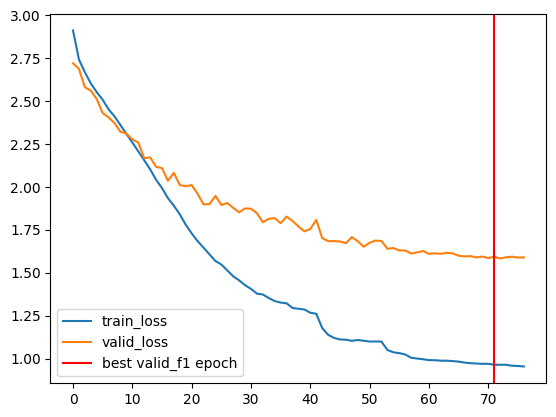

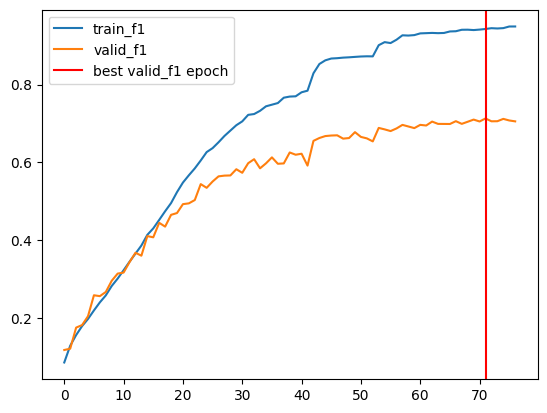

In [22]:
plot_train_history_from_results(train_results)

# Предсказание

In [23]:
# Соберем pandas DataFrame для тестовых данных и из него сделаем тестовый датасет
file_list = os.listdir('/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_test')
img_id_list = [int(file_name.split(".")[0]) for file_name in file_list]

In [24]:
test_df = pd.DataFrame({
    "img_id": img_id_list,
    "target_feature": -1
})
test_df

,img_id,target_feature
0,16916,-1
1,12666,-1
2,623,-1
3,11925,-1
4,2008,-1
...,...,...
5296,728,-1
5297,1656,-1
5298,3361,-1
5299,2599,-1


In [25]:
test_dataset = ImageDataset(
    df=test_df,
    img_dir="/kaggle/input/ml-intensive-yandex-academy-spring-2025/human_poses_data/img_test",
    transform=transform_valid
)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [26]:
# Предскажем моделью с последней эпохи
test_pred = predict_model(model, test_dataloader, device)

# Сохраним предсказание в таблицу
test_df['target_feature'] = test_pred

# Мы заменяли 20 классов на наши 16 - теперь надо вернуть исходные классы
test_df['target_feature'] = test_df['target_feature'].replace(class_id_to_target_feature)

# В результатах требуется колонка id (маленькими буквами)
test_df["id"] = test_df['img_id']

# Запишим колонки id и target_feature в csv файл. Указываем index=False, чтобы не добавлялась еще одна колонка с индексом
test_df[['id', 'target_feature']].to_csv('result_last.csv', index=False)

[1/21]   5%|4          [00:00<?]

(5301, 16)
(5301,)


In [27]:
# Предскажем моделью с оптимальной эпохи
model_path = train_results['checkpointer'].last_checkpoint
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
model = model.to(device)

test_pred = predict_model(model, test_dataloader, device)

# Сохраним предсказание в таблицу
test_df['target_feature'] = test_pred

# Мы заменяли 20 классов на наши 16 - теперь надо вернуть исходные классы
test_df['target_feature'] = test_df['target_feature'].replace(class_id_to_target_feature)

# В результатах требуется колонка id (маленькими буквами)
test_df["id"] = test_df['img_id']

# Запишим колонки id и target_feature в csv файл. Указываем index=False, чтобы не добавлялась еще одна колонка с индексом
test_df[['id', 'target_feature']].to_csv('result_best_1.csv', index=False)

[1/21]   5%|4          [00:00<?]

(5301, 16)
(5301,)


In [28]:
# Предскажем средним с трех лучших эпох
model_path_list = [i.filename for i in train_results['checkpointer']._saved]
model_path_list = [train_results['checkpointer'].save_handler.dirname / i for i in model_path_list]
test_df_list = []
print(f'Сохраненные версии: {model_path_list}')

test_pred_list = []
for model_path in model_path_list:
    print(f'Предсказываем моделью: {model_path}')
    model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
    model = model.to(device)
    
    test_pred = predict_model_pred(model, test_dataloader, device)
    test_pred_list.append(test_pred)
    
# Объединим предсказания нескольких моделей
test_pred = np.stack(test_pred_list)
print(test_pred.shape)

# Усредним предсказания 
test_pred = test_pred.mean(axis=0)
print(test_pred.shape)

# Максимум это предсказанный класс
test_pred = test_pred.argmax(1)
print(test_pred.shape)

# Сохраним предсказание в таблицу
test_df['target_feature'] = test_pred
    
# Мы заменяли 20 классов на наши 16 - теперь надо вернуть исходные классы
test_df['target_feature'] = test_df['target_feature'].replace(class_id_to_target_feature)
    
# В результатах требуется колонка id (маленькими буквами)
test_df["id"] = test_df['img_id']

# Запишим колонки id и target_feature в csv файл. Указываем index=False, чтобы не добавлялась еще одна колонка с индексом
test_df[['id', 'target_feature']].to_csv('result_best_3_mean.csv', index=False)

Сохраненные версии: [PosixPath('models/resnet18_model_0.7100.pt'), PosixPath('models/resnet18_model_0.7118.pt'), PosixPath('models/resnet18_model_0.7129.pt')]
Предсказываем моделью: models/resnet18_model_0.7100.pt


[1/21]   5%|4          [00:00<?]

(5301, 16)
Предсказываем моделью: models/resnet18_model_0.7118.pt


[1/21]   5%|4          [00:00<?]

(5301, 16)
Предсказываем моделью: models/resnet18_model_0.7129.pt


[1/21]   5%|4          [00:00<?]

(5301, 16)
(3, 5301, 16)
(5301, 16)
(5301,)
